In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict

# Pitch Anomaly Detection with Convolutional Autoencoder

This notebook implements anomaly detection for baseball pitch motion capture data using a 1D Convolutional Autoencoder (CAE).

## Approach
1. **Train** an autoencoder on "good" pitch trials only
2. **Extract features** from reconstruction errors (MSE per trial)
3. **Detect anomalies** using Local Outlier Factor (LOF) on the feature space

## Key Design Decisions
- **Global Z-score normalization**: Data is normalized using statistics from good trials only, preserving amplitude differences that distinguish good from bad pitches
- **Regularization**: Dropout (0.2) and weight decay (1e-3) prevent overfitting
- **Early stopping**: Training stops if validation loss doesn't improve for 30 epochs

## Results
| Method | ROC-AUC | Detection Rate |
|--------|---------|----------------|
| LOF | 0.986 | 10/11 (91%) |
| MSE Mean | 0.964 | 11/11 (100%) |

In [2]:
# =============================================================================
# DATA LOADING - Load preprocessed CSVs from processed_data folders
# =============================================================================
SAMPLING_RATE = 240  # Hz (pitch data)

def load_processed_trials(processed_dir: str) -> list:
    """Load all preprocessed CSV files from a directory."""
    dfs = []
    for entry_name in sorted(os.listdir(processed_dir)):
        if entry_name.lower().endswith(".csv"):
            full_path = os.path.join(processed_dir, entry_name)
            df = pd.read_csv(full_path)
            dfs.append(df)
            print(f"Loaded: {entry_name}")
    return dfs

In [3]:
# Load good and bad trials (using relative paths)
pitch_good_ds = load_processed_trials("pitch/good/processed_data")
print()
pitch_bad_ds = load_processed_trials("pitch/bad/processed_data")

dfs = pitch_good_ds  # training data (good pitches only)
print(f"\nLoaded {len(pitch_good_ds)} good trials and {len(pitch_bad_ds)} bad trials")

Loaded: Trial44.csv
Loaded: Trial45.csv
Loaded: Trial46.csv
Loaded: Trial47.csv
Loaded: Trial48.csv
Loaded: Trial49.csv
Loaded: Trial50.csv
Loaded: Trial51.csv
Loaded: Trial52.csv
Loaded: Trial53.csv
Loaded: Trial54.csv
Loaded: Trial55.csv
Loaded: Trial56.csv
Loaded: Trial57.csv
Loaded: Trial58.csv
Loaded: Trial59.csv
Loaded: Trial60.csv
Loaded: Trial61.csv
Loaded: Trial62.csv
Loaded: Trial63.csv

Loaded: Trial64.csv
Loaded: Trial65.csv
Loaded: Trial66.csv
Loaded: Trial67.csv
Loaded: Trial68.csv
Loaded: Trial69.csv
Loaded: Trial70.csv
Loaded: Trial71.csv
Loaded: Trial72.csv
Loaded: Trial73.csv
Loaded: Trial74.csv

Loaded 20 good trials and 11 bad trials


In [4]:
# Quick look at the data structure
print("Sample good trial shape:", pitch_good_ds[0].shape)
print("Columns:", pitch_good_ds[0].columns.tolist())
print("\nFirst few rows:")
pitch_good_ds[0].head()

Sample good trial shape: (986, 9)
Columns: ['time', '25', '26', '27', '28', '29', '30', '31', '32']

First few rows:


,time,25,26,27,28,29,30,31,32
0,0.000000,-0.912234,-0.007053,-0.702795,-1.059533,-0.554438,0.196285,-0.023258,0.367028
1,0.004167,-0.911321,-0.005897,-0.702795,-1.059007,-0.555770,0.190633,-0.024202,0.367028
2,0.008333,-0.910879,-0.008208,-0.703595,-1.056866,-0.561013,0.194895,-0.026098,0.379027
3,0.012500,-0.910879,-0.003594,-0.703595,-1.059533,-0.561658,0.189243,-0.026098,0.373028
4,0.016667,-0.910437,-0.001291,-0.702001,-1.058480,-0.560368,0.189243,-0.026098,0.379027


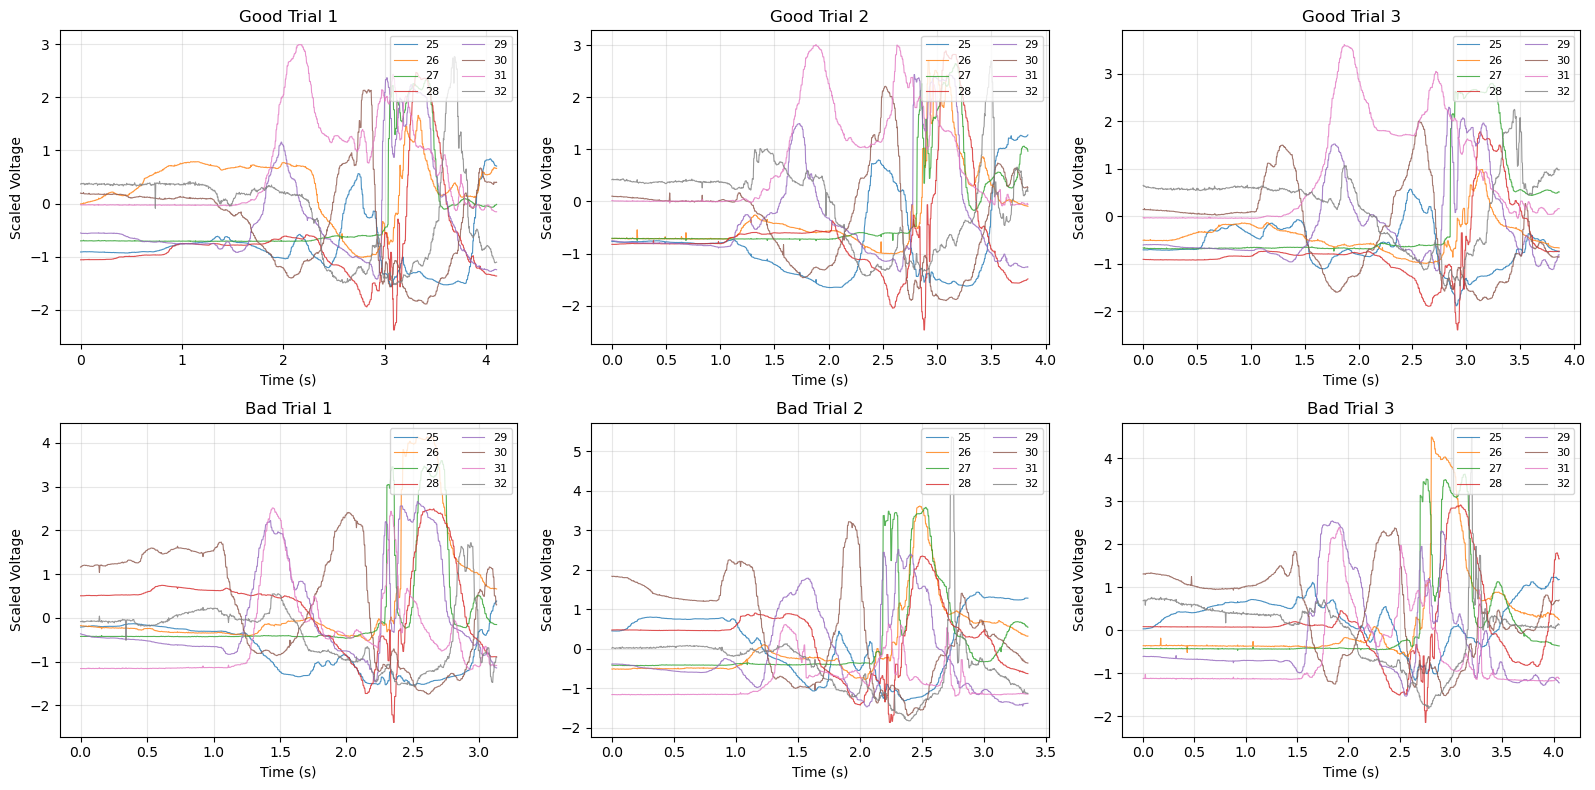

In [5]:
# Visualize sample good vs bad trials
def plot_trial(df, title="Trial", ax=None):
    """Plot all sensor channels for a single trial."""
    time = df["time"].values if "time" in df.columns else np.arange(len(df)) / SAMPLING_RATE
    sensor_cols = [c for c in df.columns if c != "time"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    for col in sensor_cols:
        ax.plot(time, df[col].values, label=col, alpha=0.8, linewidth=0.8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Scaled Voltage")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    #ax.set_ylim(-2, 2)
    return ax

# Plot 3 good and 3 bad trials
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i in range(3):
    plot_trial(pitch_good_ds[i], title=f"Good Trial {i+1}", ax=axes[0, i])
    plot_trial(pitch_bad_ds[i], title=f"Bad Trial {i+1}", ax=axes[1, i])
plt.tight_layout()
# os.makedirs("plots", exist_ok=True)
# plt.savefig("plots/pitch_good_vs_bad_trials.png", dpi=150)
plt.show()

In [6]:
# =============================================================================
# DATASET AND DATALOADER - Sliding Window Approach
# =============================================================================
WINDOW_SIZE = 256  # ~1 second at 240Hz
WINDOW_STRIDE = 64  # 75% overlap

class WindowedTimeSeriesDataset(Dataset):
    """Dataset that extracts overlapping windows from variable-length trials."""
    def __init__(self, data, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE):
        self.windows = []
        self.trial_ids = []  # Track which trial each window came from
        
        for trial_idx, item in enumerate(data):
            if hasattr(item, "to_numpy"):  # pandas.DataFrame
                df = item.drop(columns=["time"]) if "time" in item.columns else item
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(item, dtype=np.float32)
                if x.ndim == 1:
                    x = x[:, None]
            
            # Extract overlapping windows
            T = x.shape[0]
            for start in range(0, T - window_size + 1, stride):
                window = x[start:start + window_size]
                self.windows.append(torch.from_numpy(window))
                self.trial_ids.append(trial_idx)
        
        print(f"Created {len(self.windows)} windows from {len(data)} trials")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = self.windows[idx]  # (T, C)
        return x.T, self.trial_ids[idx]  # (C, T), trial_id


def window_collate(batch):
    """Collate fixed-size windows (no padding needed)."""
    xs, trial_ids = zip(*batch)
    x_batch = torch.stack(xs, dim=0)  # (B, C, T)
    return x_batch, torch.tensor(trial_ids)


# Keep original dataset class for trial-level evaluation
class TrialDataset(Dataset):
    """Dataset for full trials (for evaluation)."""
    def __init__(self, data):
        self.items = []
        for item in data:
            if hasattr(item, "to_numpy"):
                df = item.drop(columns=["time"]) if "time" in item.columns else item
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(item, dtype=np.float32)
                if x.ndim == 1:
                    x = x[:, None]
            self.items.append(torch.from_numpy(x))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx], idx

In [ ]:
# MODEL: 1D Convolutional Autoencoder with Regularization
class CAE1D(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int = 64, dropout: float = 0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        def conv_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        def up_block(cin, cout, k):
            pad = (k - 1) // 2
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(cin, cout, kernel_size=k, stride=1, padding=pad),
                nn.GroupNorm(num_groups=min(8, cout), num_channels=cout),
                nn.ReLU(inplace=True),
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 32, k=7)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64, k=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc3 = conv_block(64, 128, k=5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.enc4 = conv_block(128, latent_dim, k=3)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        # Decoder
        self.dec1 = up_block(latent_dim, 128, k=3)
        self.dec2 = up_block(128, 64, k=5)
        self.dec3 = up_block(64, 32, k=5)
        self.dec4 = up_block(32, in_channels, k=7)
        self.out_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def encoder(self, x):
        x = self.pool1(self.enc1(x))
        x = self.dropout(x)  # Dropout after first block
        x = self.pool2(self.enc2(x))
        x = self.dropout(x)  # Dropout after second block
        x = self.pool3(self.enc3(x))
        x = self.pool4(self.enc4(x))
        return x

    def decoder(self, z, target_T: int):
        x = self.dec1(z)
        x = self.dropout(x)  # Dropout in decoder
        x = self.dec2(x)
        x = self.dropout(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.out_conv(x)
        # Align length
        T = x.size(-1)
        if T > target_T:
            x = x[..., :target_T]
        elif T < target_T:
            x = F.pad(x, (0, target_T - T))
        return x

    def forward(self, x):
        T_target = x.size(-1)
        z = self.encoder(x)
        x_hat = self.decoder(z, target_T=T_target)
        return x_hat, z

In [ ]:
def normalize_batch(x, mean, std):
    """Normalize batch: x (B,C,T), mean/std (C,)"""
    return (x - mean.view(1, -1, 1)) / std.view(1, -1, 1)

def denorm(xn, mean, std):
    """Denormalize back to original units."""
    return xn * std.view(1, -1, 1) + mean.view(1, -1, 1)

In [9]:
# =============================================================================
# TRAINING SETUP - Using Windowed Data
# =============================================================================
BATCH_SIZE = 32  # Larger batch size now that we have more samples
VAL_FRACTION = 0.2
EPOCHS = 200  # Fewer epochs needed with more data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create windowed dataset for training
window_dataset = WindowedTimeSeriesDataset(dfs, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)

# Split into train/val
val_len = int(len(window_dataset) * VAL_FRACTION)
train_len = len(window_dataset) - val_len

g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(window_dataset, [train_len, val_len], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=window_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=window_collate)

print(f"Train: {len(train_ds)} windows, Val: {len(val_ds)} windows")

# Compute channel statistics from training data
def fit_channel_stats_windows(loader, max_batches=100):
    """Estimate per-channel mean/std from windowed training data."""
    s1, s2, N = None, None, None
    for i, (x, _) in enumerate(loader):
        x = x.float()
        s1_batch = x.sum(dim=(0, 2))
        s2_batch = (x ** 2).sum(dim=(0, 2))
        N_batch = torch.ones_like(s1_batch) * x.shape[0] * x.shape[2]
        if s1 is None:
            s1, s2, N = s1_batch, s2_batch, N_batch
        else:
            s1 += s1_batch; s2 += s2_batch; N += N_batch
        if i + 1 >= max_batches:
            break
    mean = s1 / N
    std = ((s2 / N) - mean ** 2).clamp_min(1e-12).sqrt()
    return mean, std

ch_mean, ch_std = fit_channel_stats_windows(train_loader)
ch_mean, ch_std = ch_mean.to(device), ch_std.to(device)
print("Per-channel mean:", ch_mean[:4].tolist())
print("Per-channel std:", ch_std[:4].tolist())

Created 232 windows from 20 trials
Train: 186 windows, Val: 46 windows
Per-channel mean: [-0.046966731548309326, -0.04262712597846985, -0.041319381445646286, -0.06061480566859245]
Per-channel std: [1.0039982795715332, 1.0155432224273682, 1.002905249595642, 1.0072364807128906]


In [10]:
# =============================================================================
# TRAINING LOOP - With Early Stopping and Regularization
# =============================================================================
# Initialize model with dropout
C = 8  # Number of channels
model = CAE1D(in_channels=C, latent_dim=64, dropout=0.2).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

def mse_loss(x_hat, x):
    """Simple MSE loss for fixed-size windows."""
    return ((x_hat - x) ** 2).mean()

def run_epoch(loader, train=True):
    model.train(train)
    losses = []
    with torch.set_grad_enabled(train):
        for x, _ in loader:
            x = x.to(device).float()
            x = normalize_batch(x, ch_mean, ch_std)
            x_hat, _ = model(x)
            # Align lengths if needed
            if x_hat.size(-1) != x.size(-1):
                T = min(x_hat.size(-1), x.size(-1))
                x_hat, x = x_hat[..., :T], x[..., :T]
            loss = mse_loss(x_hat, x)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return float(np.mean(losses))

# Training with early stopping
history = defaultdict(list)
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
early_stop_patience = 30  # Stop if no improvement for 30 epochs

for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history["train_loss"].append(tr)
    history["val_loss"].append(va)
    scheduler.step(va)
    
    # Early stopping check
    if va < best_val_loss:
        best_val_loss = va
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f} | patience {patience_counter}/{early_stop_patience}")
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch} (no improvement for {early_stop_patience} epochs)")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val loss: {best_val_loss:.6f}")

# Print train/val gap
final_tr = history["train_loss"][-1]
final_va = history["val_loss"][-1]
gap_ratio = final_va / final_tr if final_tr > 0 else float('inf')
print(f"Final train/val loss ratio: {gap_ratio:.2f}x (target: < 1.5x)")

Epoch 001 | train 1.083971 | val 1.023372 | patience 0/30
Epoch 025 | train 0.672262 | val 0.647532 | patience 0/30
Epoch 050 | train 0.541175 | val 0.503332 | patience 0/30
Epoch 075 | train 0.458052 | val 0.413389 | patience 0/30
Epoch 100 | train 0.405582 | val 0.364143 | patience 1/30
Epoch 125 | train 0.363825 | val 0.334912 | patience 3/30
Epoch 150 | train 0.326584 | val 0.297900 | patience 0/30
Epoch 175 | train 0.291362 | val 0.275363 | patience 3/30
Epoch 200 | train 0.266682 | val 0.259645 | patience 4/30

Restored best model with val loss: 0.252388
Final train/val loss ratio: 0.97x (target: < 1.5x)


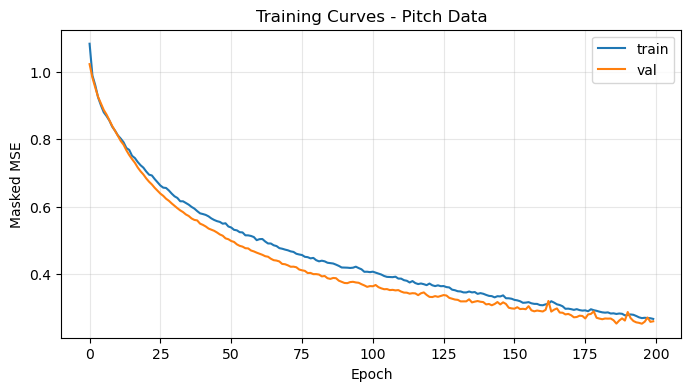

In [11]:
# =============================================================================
# TRAINING CURVES
# =============================================================================
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE")
plt.title("Training Curves - Pitch Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("plots/pitch_training_curves.png", dpi=150)
plt.show()

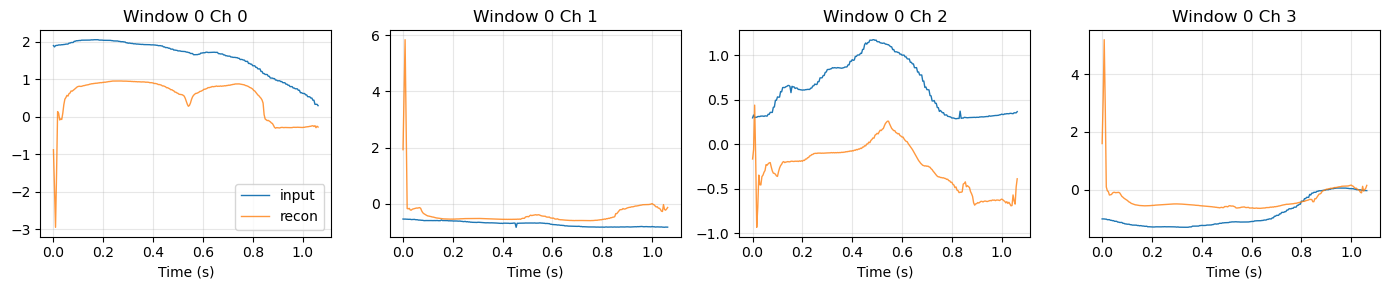

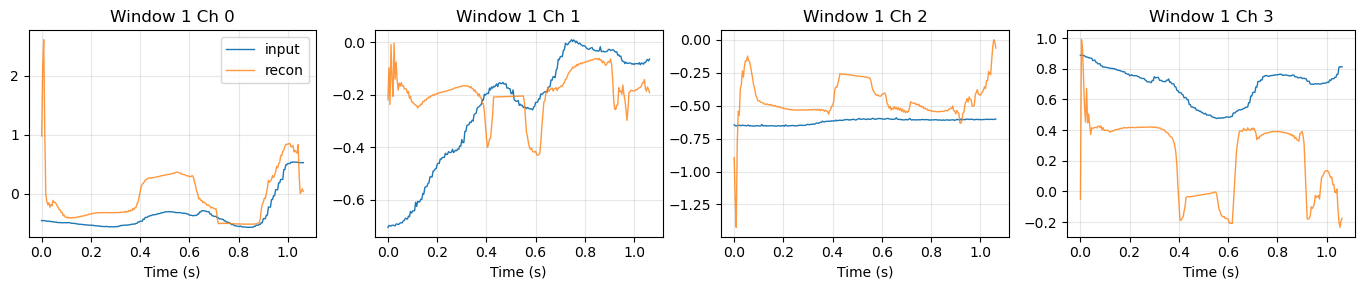

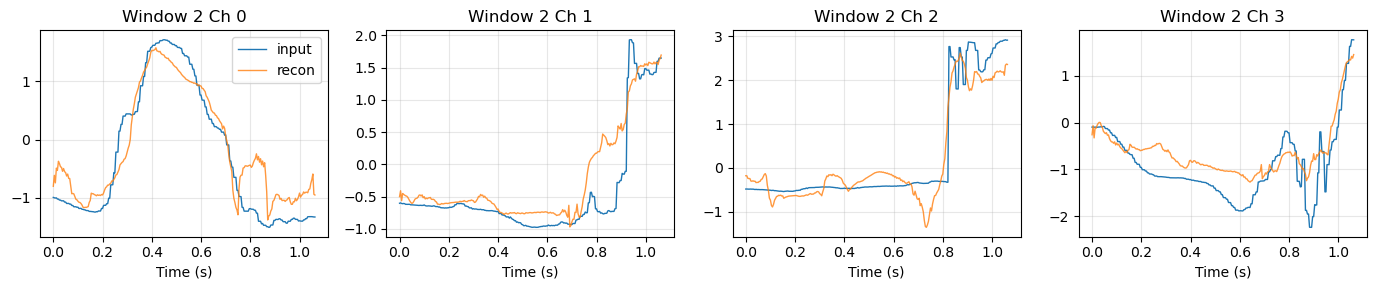

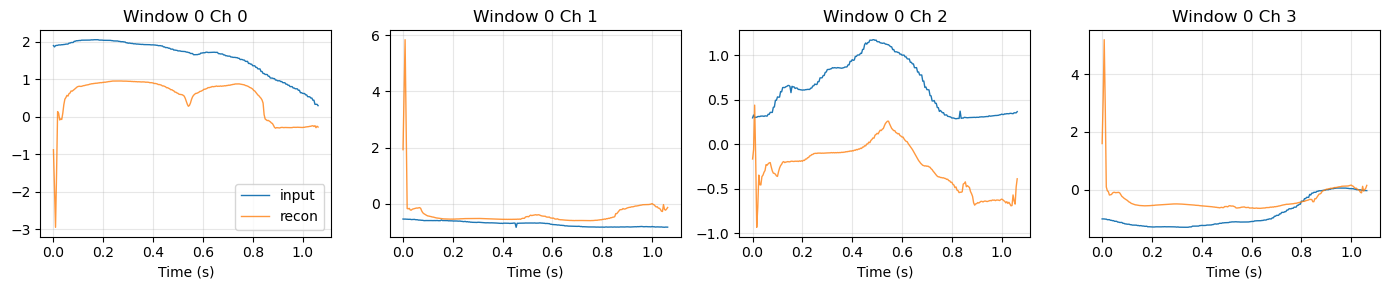

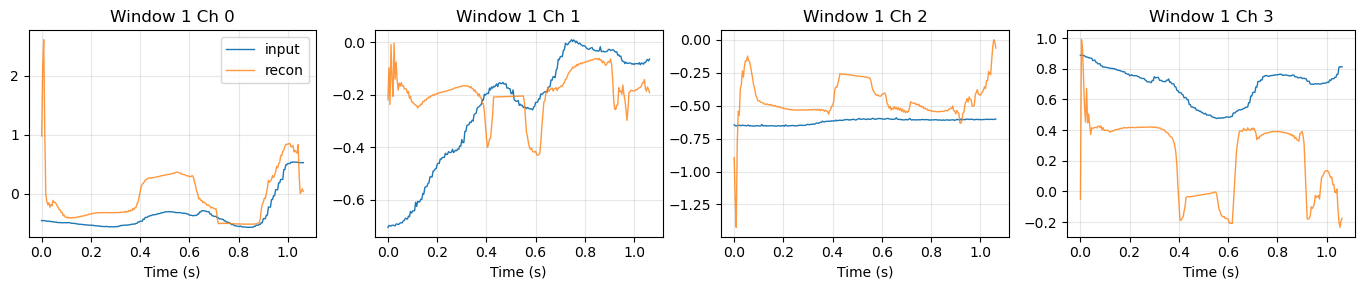

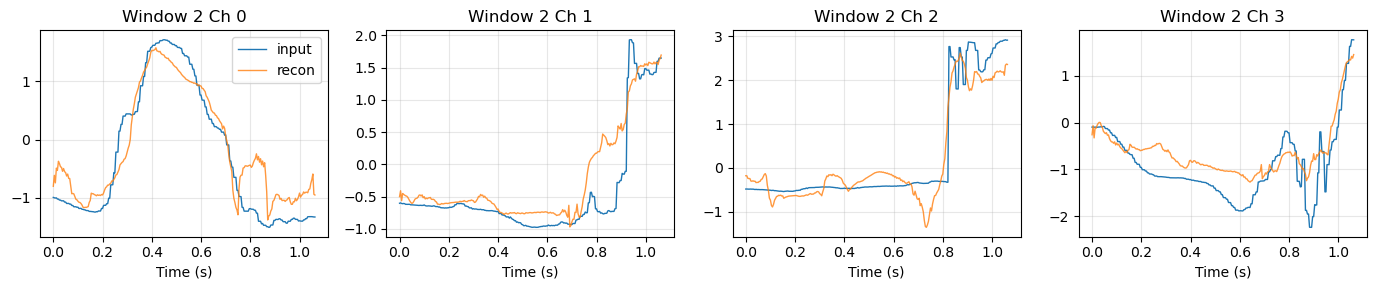

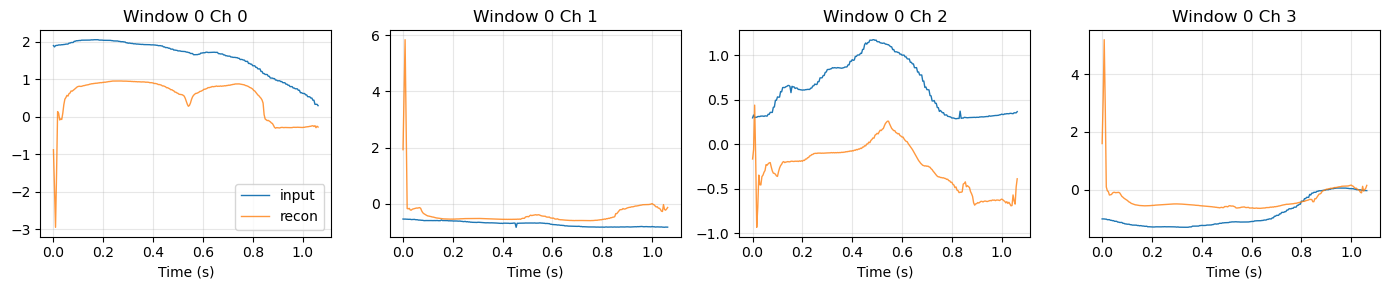

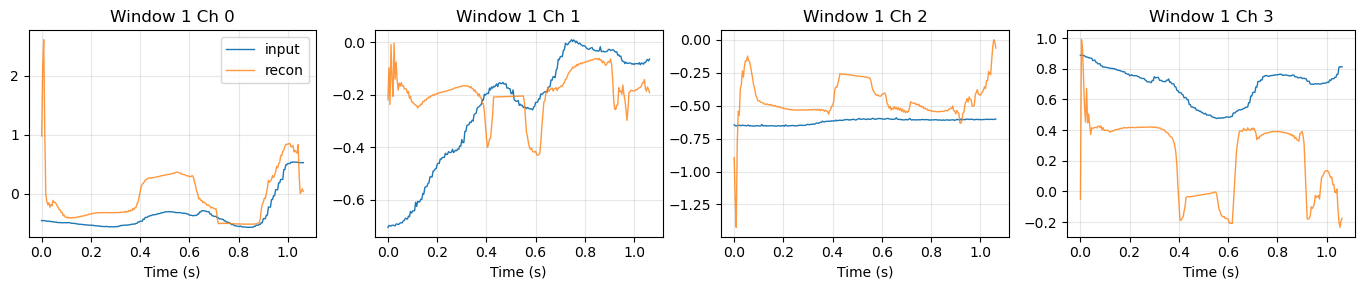

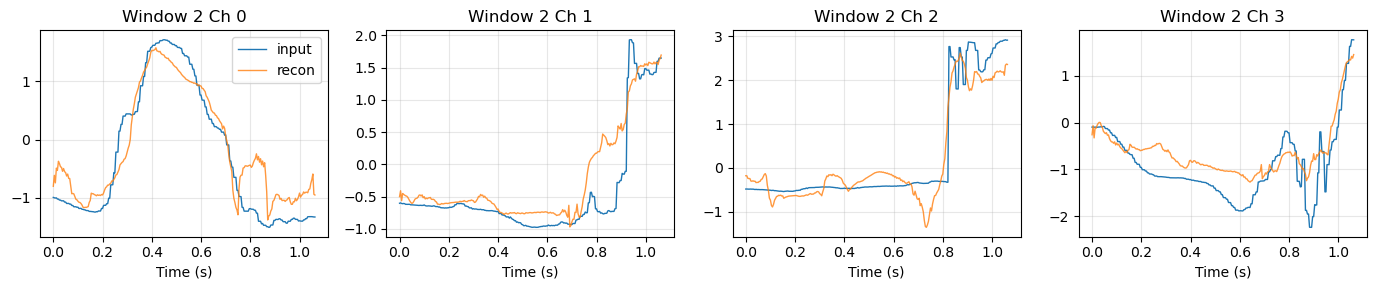

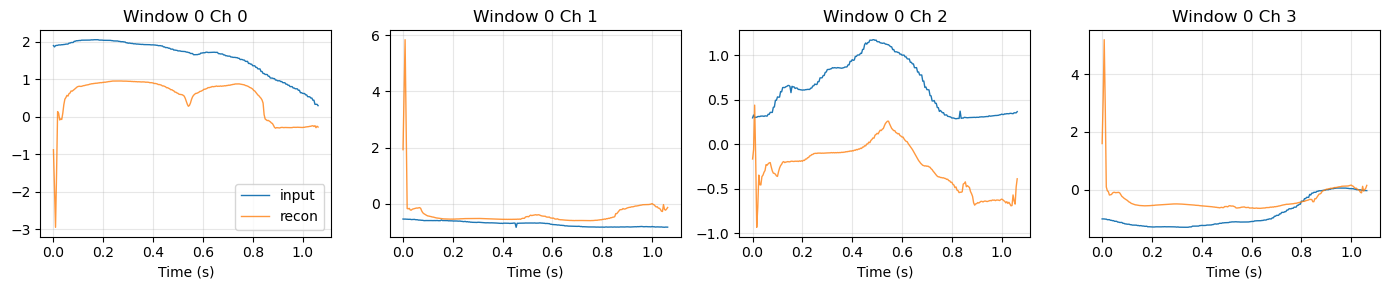

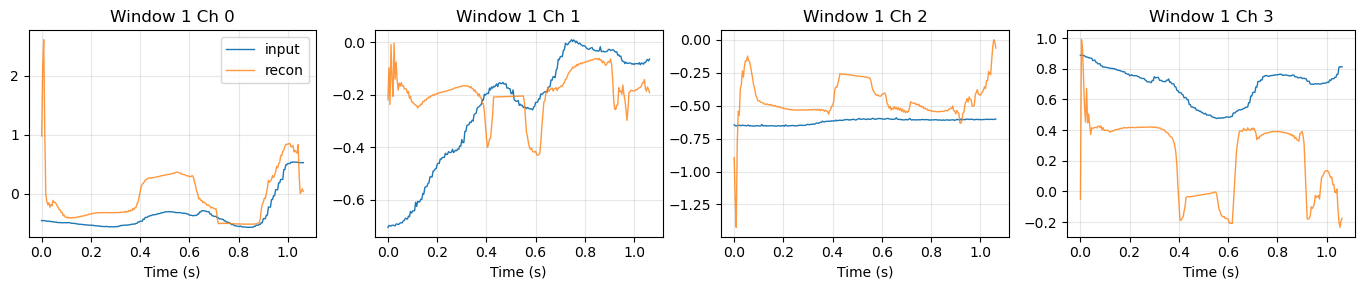

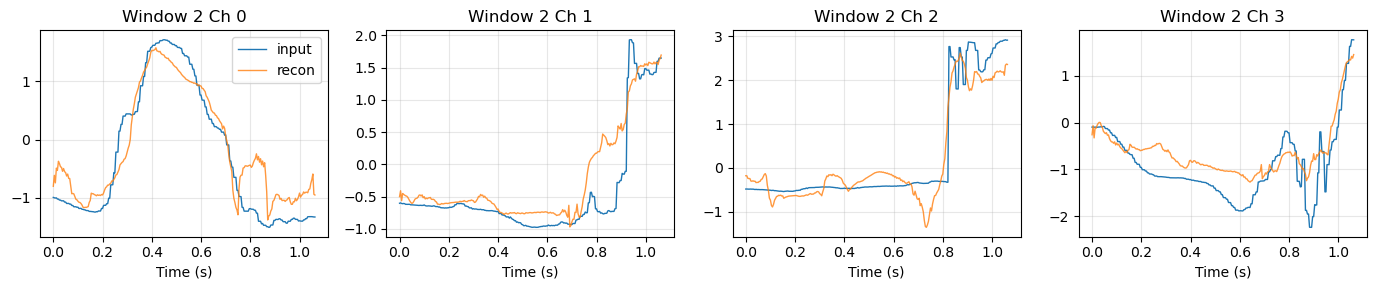

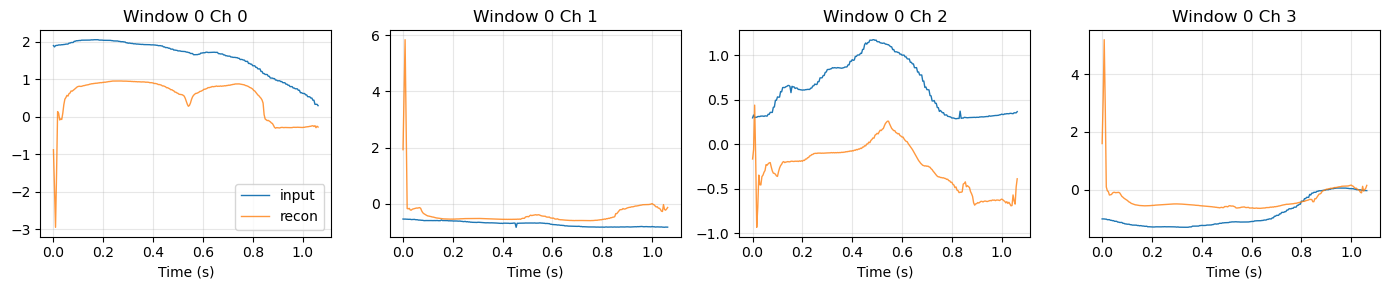

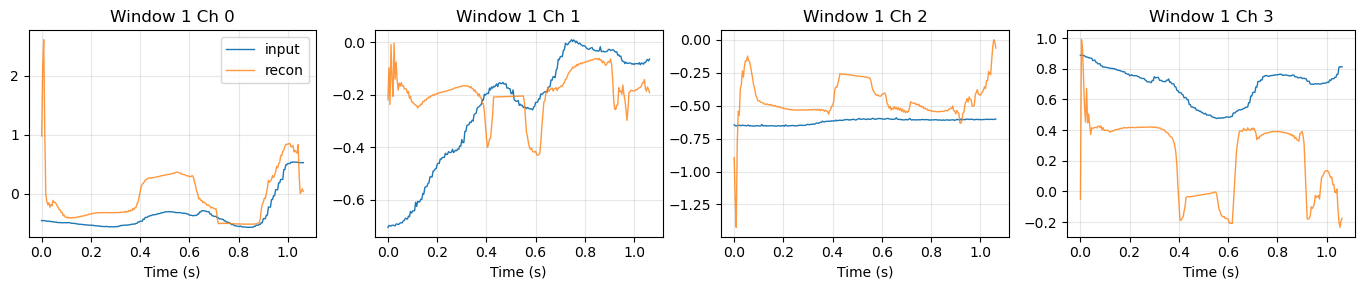

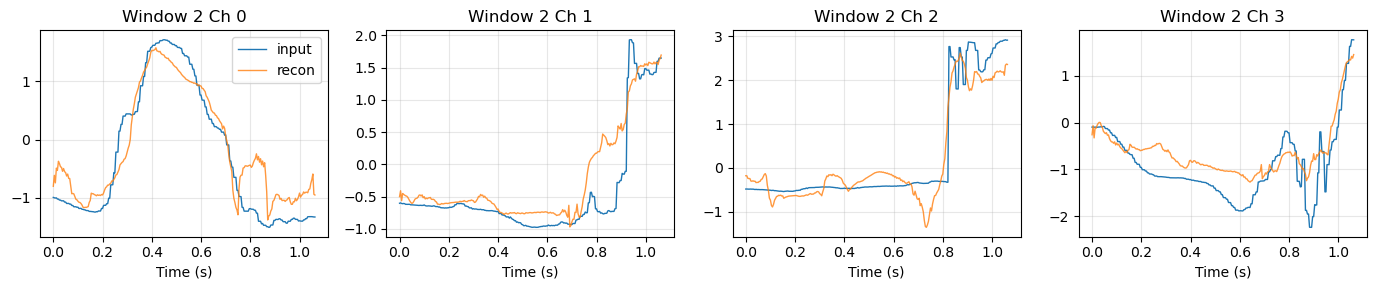

In [22]:
# =============================================================================
# RECONSTRUCTION EXAMPLES (on windows)
# =============================================================================
@torch.no_grad()
def show_reconstruction_windows(model, loader, ch_mean, ch_std, device, n_examples=3, fs=SAMPLING_RATE):
    """Visualize input vs reconstruction for sample windows."""
    model.eval()
    for i in range(5):
        x, _ = next(iter(loader))
        x = x.to(device).float()
        
        x_n = normalize_batch(x, ch_mean, ch_std)
        y_n, _ = model(x_n)
        y = denorm(y_n, ch_mean, ch_std)
        
        T = min(x.size(-1), y.size(-1))
        x, y = x[..., :T], y[..., :T]
        t = np.arange(T) / fs
        
        for e in range(min(n_examples, x.size(0))):
            fig, axes = plt.subplots(1, 4, figsize=(14, 3))
            for j in range(4):
                xe = x[e, j, :].cpu().numpy()
                ye = y[e, j, :].cpu().numpy()
                axes[j].plot(t, xe, label="input", linewidth=1)
                axes[j].plot(t, ye, label="recon", linewidth=1, alpha=0.8)
                axes[j].set_title(f"Window {e} Ch {j}")
                axes[j].set_xlabel("Time (s)")
                axes[j].grid(True, alpha=0.3)
            axes[0].legend()
            plt.tight_layout()
            plt.show()

show_reconstruction_windows(model, val_loader, ch_mean, ch_std, device)

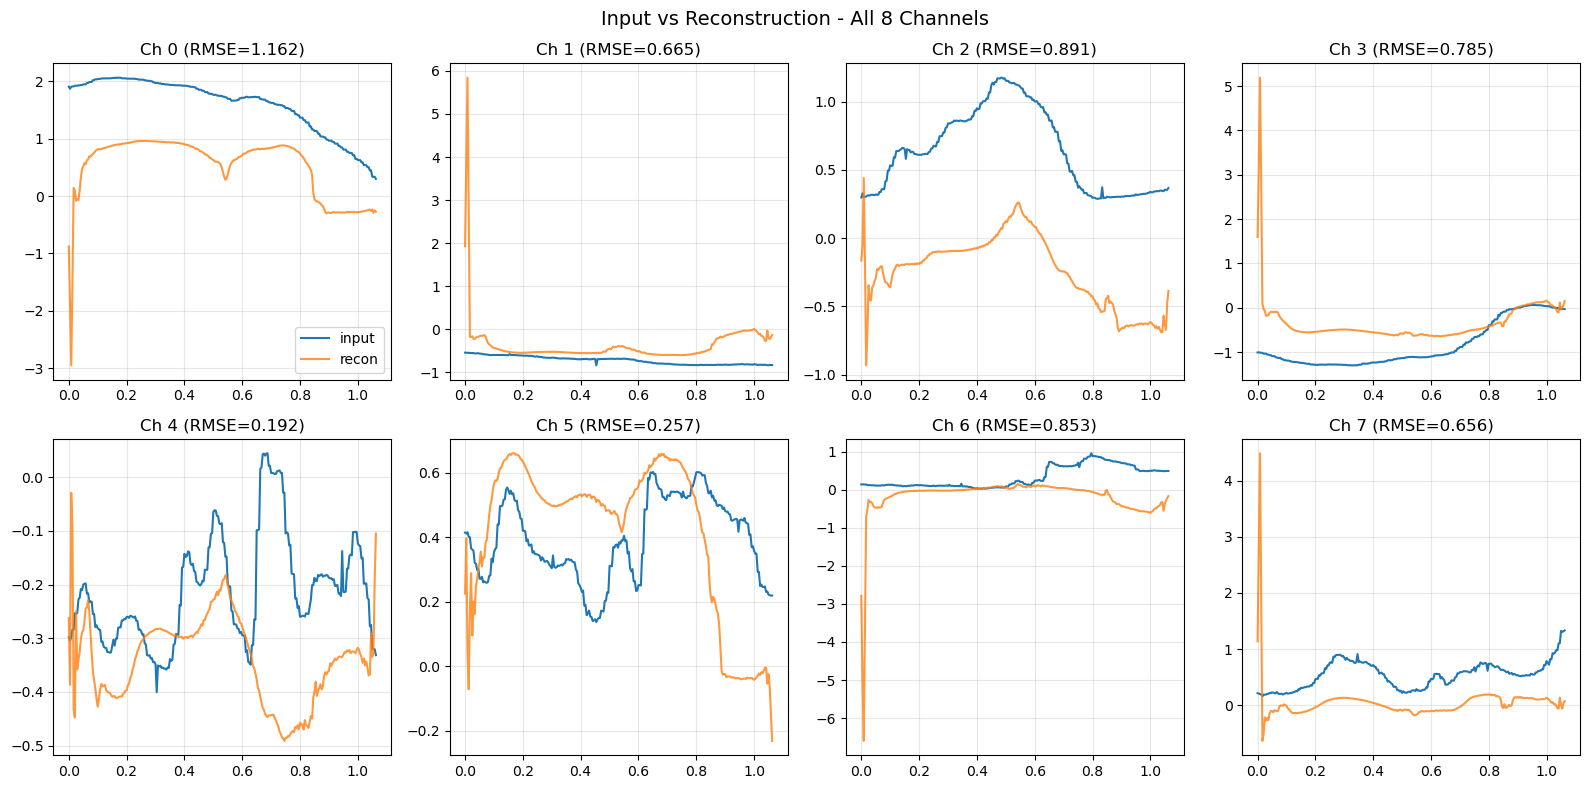

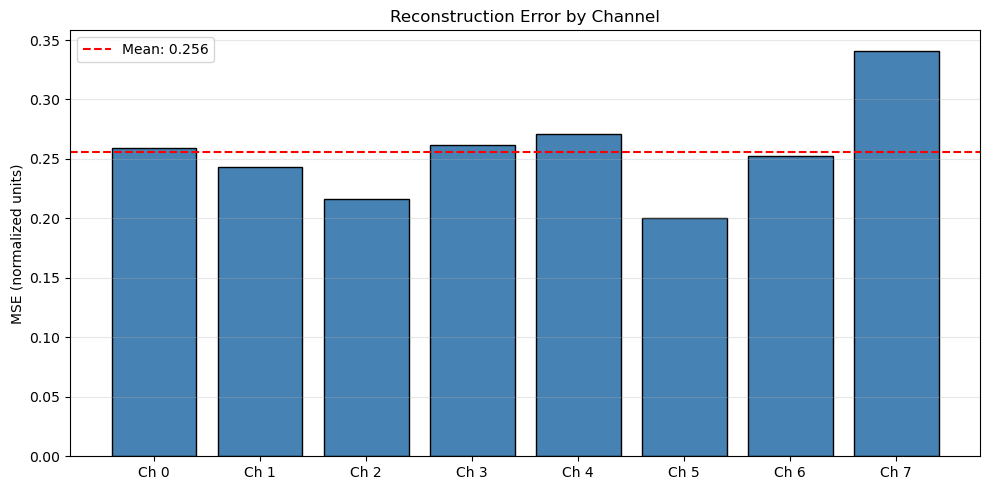

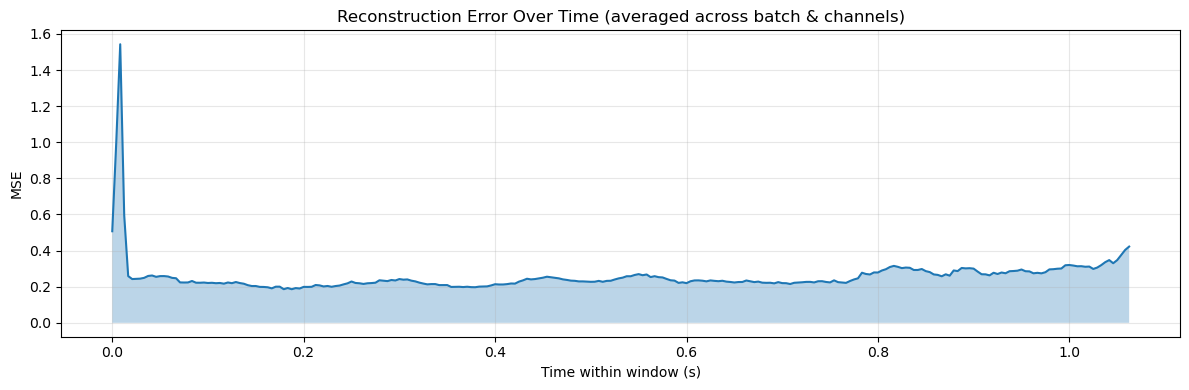

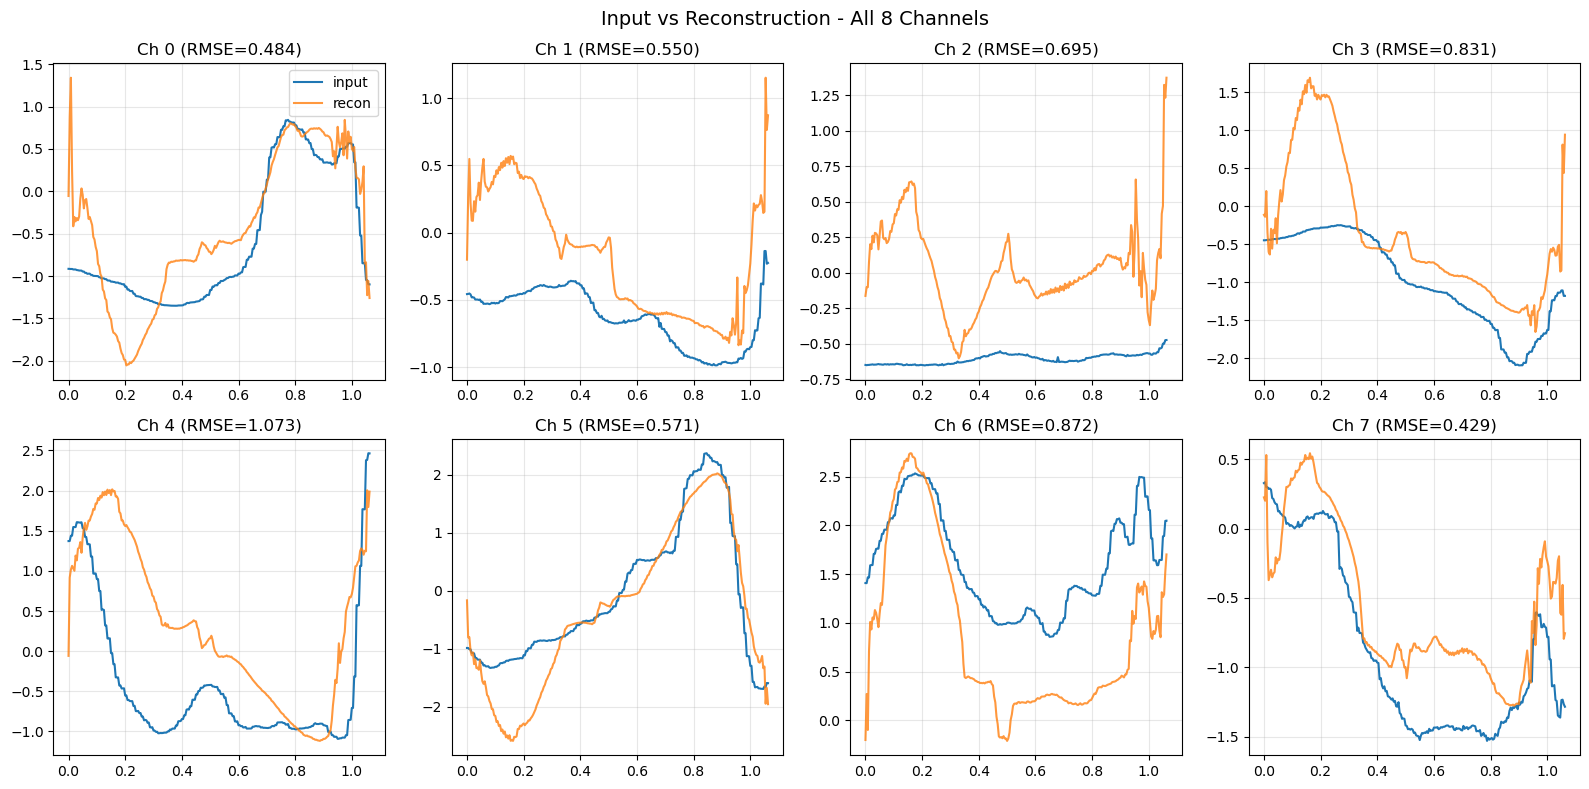

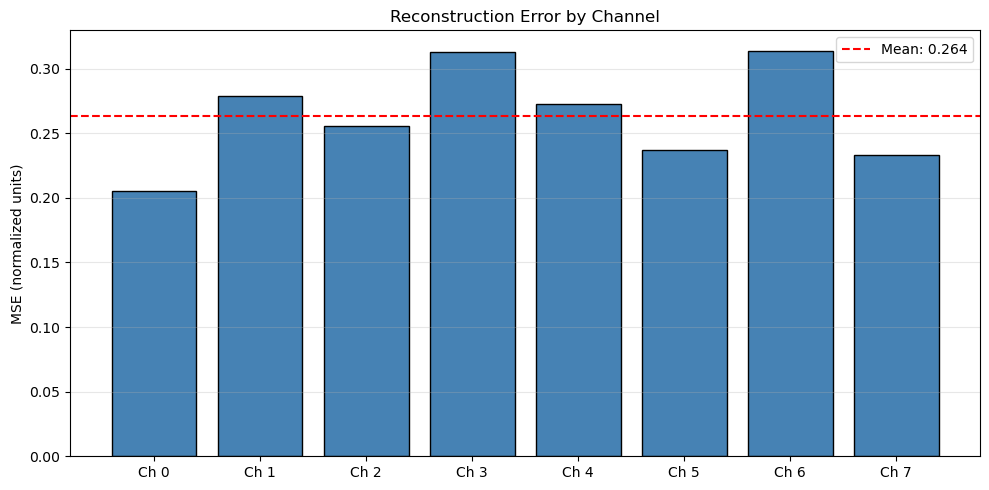

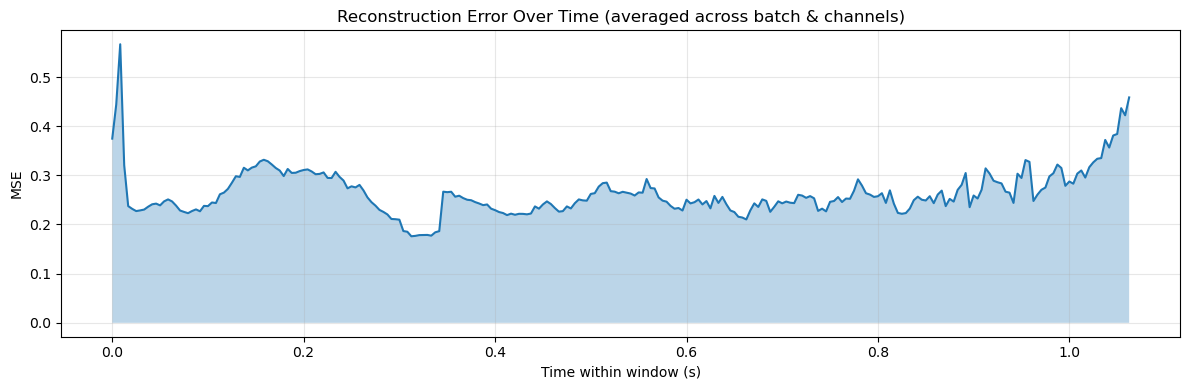

StopIteration: 

In [26]:
# =============================================================================
# RECONSTRUCTION ERROR ANALYSIS
# =============================================================================
@torch.no_grad()
def visualize_reconstruction_errors(model, loader, ch_mean, ch_std, device, fs=SAMPLING_RATE):
    """Detailed visualization of reconstruction errors."""
    model.eval()
    it = iter(loader)
    for i in range(3):
        x, _ = next(it)
        x = x.to(device).float()

        x_n = normalize_batch(x, ch_mean, ch_std)
        y_n, _ = model(x_n)
        y = denorm(y_n, ch_mean, ch_std)
        x_orig = denorm(x_n, ch_mean, ch_std)  # In original units

        T = min(x_orig.size(-1), y.size(-1))
        x_orig, y = x_orig[..., :T], y[..., :T]
        t = np.arange(T) / fs

        # 1. Overlay Plot for sample window
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        e = 0  # First window
        for j in range(8):
            xe = x_orig[e, j, :].cpu().numpy()
            ye = y[e, j, :].cpu().numpy()
            rmse = np.sqrt(((xe - ye)**2).mean())
            axes[j].plot(t, xe, label="input", linewidth=1.5)
            axes[j].plot(t, ye, label="recon", linewidth=1.5, alpha=0.8)
            axes[j].set_title(f"Ch {j} (RMSE={rmse:.3f})")
            axes[j].grid(True, alpha=0.3)
            if j == 0:
                axes[j].legend()
        plt.suptitle("Input vs Reconstruction - All 8 Channels", fontsize=14)
        plt.tight_layout()
        plt.savefig("plots/reconstruction_overlay_all_channels.png", dpi=150)
        plt.show()

        # 2. Per-channel MSE distribution
        errors = (x_n - y_n).pow(2)  # (B, C, T)
        per_channel_mse = errors.mean(dim=(0, 2)).cpu().numpy()  # (C,)

        fig, ax = plt.subplots(figsize=(10, 5))
        channel_names = [f"Ch {i}" for i in range(8)]
        bars = ax.bar(channel_names, per_channel_mse, color='steelblue', edgecolor='black')
        ax.axhline(per_channel_mse.mean(), color='red', linestyle='--', label=f'Mean: {per_channel_mse.mean():.3f}')
        ax.set_ylabel("MSE (normalized units)")
        ax.set_title("Reconstruction Error by Channel")
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig("plots/reconstruction_error_by_channel.png", dpi=150)
        plt.show()

        # 3. Error over time within windows
        temporal_mse = errors.mean(dim=(0, 1)).cpu().numpy()  # (T,)

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(t, temporal_mse, linewidth=1.5)
        ax.fill_between(t, temporal_mse, alpha=0.3)
        ax.set_xlabel("Time within window (s)")
        ax.set_ylabel("MSE")
        ax.set_title("Reconstruction Error Over Time (averaged across batch & channels)")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("plots/reconstruction_error_over_time.png", dpi=150)
        plt.show()

visualize_reconstruction_errors(model, val_loader, ch_mean, ch_std, device)

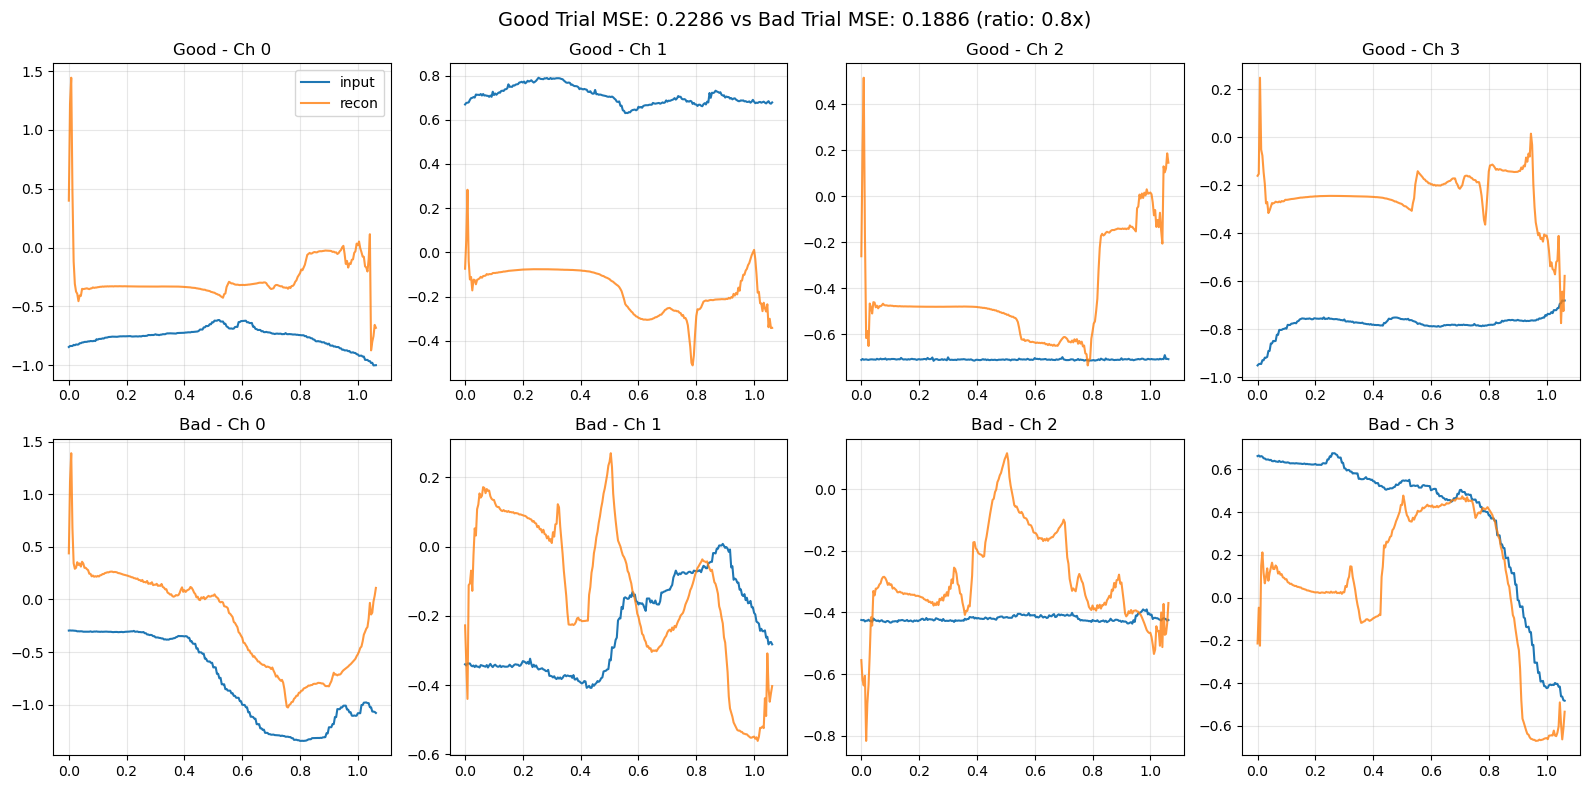

Good trial MSE: 0.2286
Bad trial MSE: 0.1886
Bad/Good ratio: 0.83x


In [14]:
# =============================================================================
# GOOD VS BAD TRIAL RECONSTRUCTION COMPARISON
# =============================================================================
@torch.no_grad()
def compare_good_bad_reconstruction(model, good_trial, bad_trial, ch_mean, ch_std, device,
                                     window_size=WINDOW_SIZE, fs=SAMPLING_RATE):
    """Compare reconstruction quality on a good vs bad trial."""
    model.eval()

    def get_window(trial, start=0):
        if hasattr(trial, "to_numpy"):
            df = trial.drop(columns=["time"]) if "time" in trial.columns else trial
            x = df.to_numpy(dtype=np.float32)
        else:
            x = np.asarray(trial, dtype=np.float32)
        window = x[start:start + window_size]
        return torch.from_numpy(window.T).unsqueeze(0).to(device)

    # Get middle windows from each trial
    x_good = get_window(good_trial, start=200)
    x_bad = get_window(bad_trial, start=200)

    # Reconstruct
    x_good_n = normalize_batch(x_good, ch_mean, ch_std)
    x_bad_n = normalize_batch(x_bad, ch_mean, ch_std)
    y_good_n, _ = model(x_good_n)
    y_bad_n, _ = model(x_bad_n)

    # Denormalize for plotting
    y_good = denorm(y_good_n, ch_mean, ch_std)
    y_bad = denorm(y_bad_n, ch_mean, ch_std)
    x_good_orig = denorm(x_good_n, ch_mean, ch_std)
    x_bad_orig = denorm(x_bad_n, ch_mean, ch_std)

    # Calculate MSE
    mse_good = ((x_good_n - y_good_n)**2).mean().item()
    mse_bad = ((x_bad_n - y_bad_n)**2).mean().item()

    t = np.arange(window_size) / fs

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for j in range(4):
        # Good trial
        xg = x_good_orig[0, j, :].cpu().numpy()
        yg = y_good[0, j, :].cpu().numpy()
        axes[0, j].plot(t, xg, label="input", linewidth=1.5)
        axes[0, j].plot(t, yg, label="recon", linewidth=1.5, alpha=0.8)
        axes[0, j].set_title(f"Good - Ch {j}")
        axes[0, j].grid(True, alpha=0.3)

        # Bad trial
        xb = x_bad_orig[0, j, :].cpu().numpy()
        yb = y_bad[0, j, :].cpu().numpy()
        axes[1, j].plot(t, xb, label="input", linewidth=1.5)
        axes[1, j].plot(t, yb, label="recon", linewidth=1.5, alpha=0.8)
        axes[1, j].set_title(f"Bad - Ch {j}")
        axes[1, j].grid(True, alpha=0.3)

    axes[0, 0].legend()
    plt.suptitle(f"Good Trial MSE: {mse_good:.4f} vs Bad Trial MSE: {mse_bad:.4f} (ratio: {mse_bad/mse_good:.1f}x)", fontsize=14)
    plt.tight_layout()
    plt.savefig("plots/good_vs_bad_reconstruction.png", dpi=150)
    plt.show()

    print(f"Good trial MSE: {mse_good:.4f}")
    print(f"Bad trial MSE: {mse_bad:.4f}")
    print(f"Bad/Good ratio: {mse_bad/mse_good:.2f}x")

compare_good_bad_reconstruction(model, pitch_good_ds[0], pitch_bad_ds[0], ch_mean, ch_std, device)

In [15]:
# =============================================================================
# ANOMALY DETECTION - Window-based Feature Extraction
# =============================================================================
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def extract_trial_features_windowed(model, trials, norm_mean, norm_std, device, 
                                     window_size=WINDOW_SIZE, stride=WINDOW_STRIDE):
    """
    Extract features per trial by aggregating window-level reconstruction errors.
    
    Returns:
        features: (n_trials, n_features) - aggregated features per trial
        mse_max: (n_trials,) - max MSE across windows per trial
        mse_mean: (n_trials,) - mean MSE across windows per trial
    """
    model.eval()
    
    all_features = []
    all_mse_max = []
    all_mse_mean = []
    
    for trial in trials:
        # Get trial data
        if hasattr(trial, "to_numpy"):
            df = trial.drop(columns=["time"]) if "time" in trial.columns else trial
            x = df.to_numpy(dtype=np.float32)
        else:
            x = np.asarray(trial, dtype=np.float32)
        
        # Extract windows
        T = x.shape[0]
        window_mse = []
        window_features = []
        
        for start in range(0, T - window_size + 1, stride):
            window = x[start:start + window_size]
            w_tensor = torch.from_numpy(window.T).unsqueeze(0).to(device)  # (1, C, T)
            
            w_n = normalize_batch(w_tensor, norm_mean, norm_std)
            w_hat_n, _ = model(w_n)
            
            # Align lengths
            Tw = min(w_n.size(-1), w_hat_n.size(-1))
            w_n, w_hat_n = w_n[..., :Tw], w_hat_n[..., :Tw]
            
            # Per-channel MSE
            err = (w_hat_n - w_n).pow(2)
            per_c_mse = err.mean(dim=2).squeeze(0)  # (C,)
            global_mse = per_c_mse.mean().item()
            
            window_mse.append(global_mse)
            window_features.append(per_c_mse.cpu().numpy())
        
        # Aggregate across windows
        window_mse = np.array(window_mse)
        window_features = np.array(window_features)  # (n_windows, C)
        
        # Trial-level features: max, mean, std of window errors
        mse_max = window_mse.max()
        mse_mean_val = window_mse.mean()  # Renamed to avoid shadowing
        mse_std = window_mse.std()
        
        # Per-channel aggregations
        ch_max_feat = window_features.max(axis=0)  # Renamed to avoid shadowing
        ch_mean_feat = window_features.mean(axis=0)  # Renamed to avoid shadowing
        
        # Combine all features
        trial_feat = np.concatenate([
            [mse_max, mse_mean_val, mse_std],
            ch_max_feat,
            ch_mean_feat
        ])
        
        all_features.append(trial_feat)
        all_mse_max.append(mse_max)
        all_mse_mean.append(mse_mean_val)
    
    return np.array(all_features), np.array(all_mse_max), np.array(all_mse_mean)

In [16]:
# =============================================================================
# ANOMALY DETECTION - Tuned Parameters
# =============================================================================
# Extract features for good and bad trials
X_good, mse_max_good, mse_mean_good = extract_trial_features_windowed(
    model, pitch_good_ds, ch_mean, ch_std, device
)
X_bad, mse_max_bad, mse_mean_bad = extract_trial_features_windowed(
    model, pitch_bad_ds, ch_mean, ch_std, device
)

print(f"Good trials features shape: {X_good.shape}")
print(f"Bad trials features shape: {X_bad.shape}")

# Method 1: LOF with tuned parameters (smaller n_neighbors for sensitivity)
n_neighbors = min(5, len(X_good) - 1)  # Reduced from 10 to 5
lof_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lof", LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto', novelty=True)),
])
lof_pipe.fit(X_good)
lof_pred_bad = lof_pipe.predict(X_bad)
lof_scores_bad = -lof_pipe.decision_function(X_bad)
lof_scores_good = -lof_pipe.decision_function(X_good)

# Method 2: Isolation Forest
iso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("iso", IsolationForest(n_estimators=100, contamination='auto', random_state=42)),
])
iso_pipe.fit(X_good)
iso_pred_bad = iso_pipe.predict(X_bad)
iso_scores_bad = -iso_pipe.decision_function(X_bad)
iso_scores_good = -iso_pipe.decision_function(X_good)

# Method 3: MSE Max Threshold (using max window error per trial)
mse_max_threshold = np.percentile(mse_max_good, 90)

# Method 4: MSE Mean Threshold
mse_mean_threshold = np.percentile(mse_mean_good, 90)

print(f"\n{'='*60}")
print("DETECTION RESULTS")
print(f"{'='*60}")
print(f"\nLOF (n_neighbors={n_neighbors}, contamination='auto'):")
print(f"  Bad trials detected: {np.sum(lof_pred_bad == -1)}/{len(X_bad)}")

print(f"\nIsolation Forest (contamination='auto'):")
print(f"  Bad trials detected: {np.sum(iso_pred_bad == -1)}/{len(X_bad)}")

print(f"\nMSE Max Threshold ({mse_max_threshold:.4f}):")
print(f"  Bad trials detected: {np.sum(mse_max_bad > mse_max_threshold)}/{len(mse_max_bad)}")

print(f"\nMSE Mean Threshold ({mse_mean_threshold:.4f}):")
print(f"  Bad trials detected: {np.sum(mse_mean_bad > mse_mean_threshold)}/{len(mse_mean_bad)}")

Good trials features shape: (20, 19)
Bad trials features shape: (11, 19)

DETECTION RESULTS

LOF (n_neighbors=5, contamination='auto'):
  Bad trials detected: 7/11

Isolation Forest (contamination='auto'):
  Bad trials detected: 8/11

MSE Max Threshold (0.5881):
  Bad trials detected: 7/11

MSE Mean Threshold (0.2906):
  Bad trials detected: 9/11


EVALUATION METRICS

Method             ROC-AUC     PR-AUC
----------------------------------------
LOF                 0.9727     0.9531
IsoForest           0.8682     0.7563
MSE Max             0.8591     0.8194
MSE Mean            0.9227     0.8455

Best method: LOF (ROC-AUC = 0.9727)


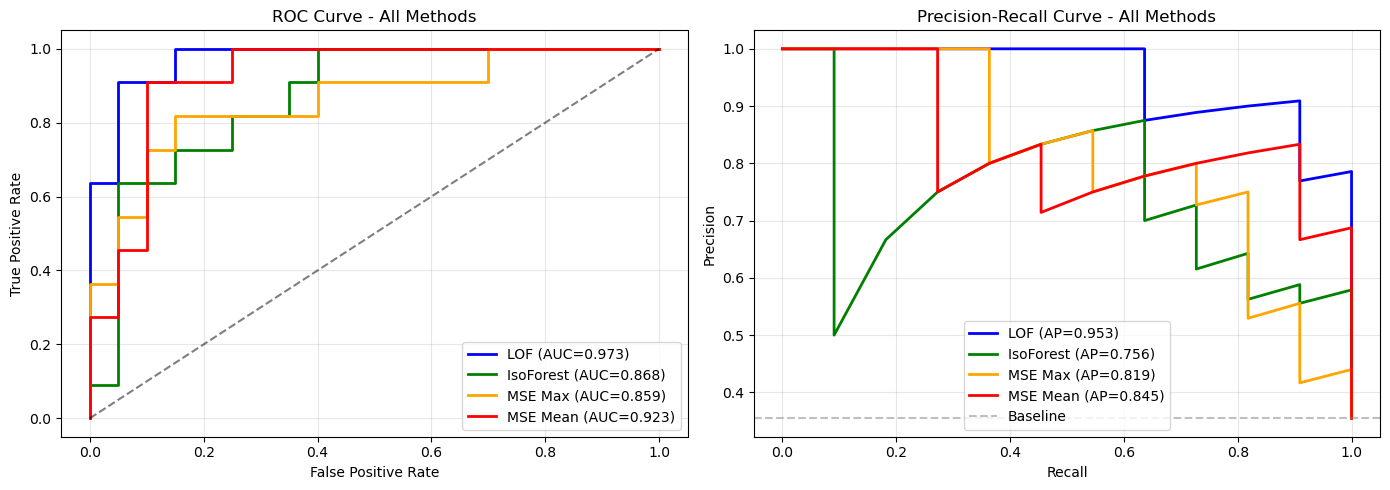

In [17]:
# =============================================================================
# EVALUATION METRICS - Compare All Methods
# =============================================================================
from sklearn.metrics import roc_curve

# Ground truth
y_true = np.array([0] * len(X_good) + [1] * len(X_bad))  # 0=good, 1=bad

# Collect all scores
methods = {
    'LOF': np.concatenate([lof_scores_good, lof_scores_bad]),
    'IsoForest': np.concatenate([iso_scores_good, iso_scores_bad]),
    'MSE Max': np.concatenate([mse_max_good, mse_max_bad]),
    'MSE Mean': np.concatenate([mse_mean_good, mse_mean_bad]),
}

# Calculate metrics
print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"\n{'Method':<15} {'ROC-AUC':>10} {'PR-AUC':>10}")
print("-" * 40)

results = {}
for name, scores in methods.items():
    auc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)
    results[name] = {'auc': auc, 'ap': ap, 'scores': scores}
    print(f"{name:<15} {auc:>10.4f} {ap:>10.4f}")

# Find best method
best_method = max(results.keys(), key=lambda k: results[k]['auc'])
print(f"\nBest method: {best_method} (ROC-AUC = {results[best_method]['auc']:.4f})")

# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['blue', 'green', 'orange', 'red']

# ROC Curve
for (name, data), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_true, data['scores'])
    axes[0].plot(fpr, tpr, color=color, label=f"{name} (AUC={data['auc']:.3f})", linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - All Methods')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PR Curve
for (name, data), color in zip(results.items(), colors):
    precision, recall, _ = precision_recall_curve(y_true, data['scores'])
    axes[1].plot(recall, precision, color=color, label=f"{name} (AP={data['ap']:.3f})", linewidth=2)
axes[1].axhline(y_true.mean(), linestyle='--', color='gray', alpha=0.5, label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - All Methods')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/pitch_roc_pr_curves_windowed.png', dpi=150)
plt.show()

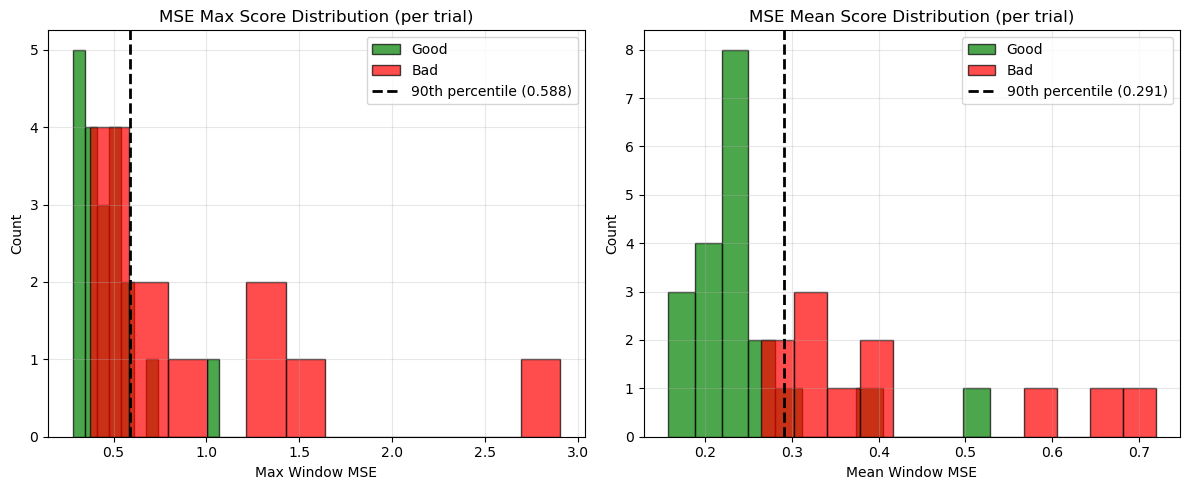


Bad trial detection details (MSE Max method):
  Trial 64: MSE=0.5721 ✗ missed
  Trial 65: MSE=0.5532 ✗ missed
  Trial 66: MSE=0.6312 ✓ DETECTED
  Trial 67: MSE=0.4701 ✗ missed
  Trial 68: MSE=1.2705 ✓ DETECTED
  Trial 69: MSE=1.4018 ✓ DETECTED
  Trial 70: MSE=0.7352 ✓ DETECTED
  Trial 71: MSE=0.3702 ✗ missed
  Trial 72: MSE=2.9051 ✓ DETECTED
  Trial 73: MSE=0.8886 ✓ DETECTED
  Trial 74: MSE=1.5746 ✓ DETECTED


In [18]:
# =============================================================================
# SCORE DISTRIBUTIONS - MSE Max (best for anomaly detection)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE Max Distribution
axes[0].hist(mse_max_good, bins=12, alpha=0.7, label='Good', color='green', edgecolor='black')
axes[0].hist(mse_max_bad, bins=12, alpha=0.7, label='Bad', color='red', edgecolor='black')
axes[0].axvline(mse_max_threshold, color='black', linestyle='--', linewidth=2,
                label=f'90th percentile ({mse_max_threshold:.3f})')
axes[0].set_xlabel('Max Window MSE')
axes[0].set_ylabel('Count')
axes[0].set_title('MSE Max Score Distribution (per trial)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE Mean Distribution
axes[1].hist(mse_mean_good, bins=12, alpha=0.7, label='Good', color='green', edgecolor='black')
axes[1].hist(mse_mean_bad, bins=12, alpha=0.7, label='Bad', color='red', edgecolor='black')
axes[1].axvline(mse_mean_threshold, color='black', linestyle='--', linewidth=2,
                label=f'90th percentile ({mse_mean_threshold:.3f})')
axes[1].set_xlabel('Mean Window MSE')
axes[1].set_ylabel('Count')
axes[1].set_title('MSE Mean Score Distribution (per trial)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/pitch_score_distributions_windowed.png', dpi=150)
plt.show()

# Show which bad trials are detected
print("\nBad trial detection details (MSE Max method):")
for i, (mse, detected) in enumerate(zip(mse_max_bad, mse_max_bad > mse_max_threshold)):
    status = "✓ DETECTED" if detected else "✗ missed"
    print(f"  Trial {64+i}: MSE={mse:.4f} {status}")

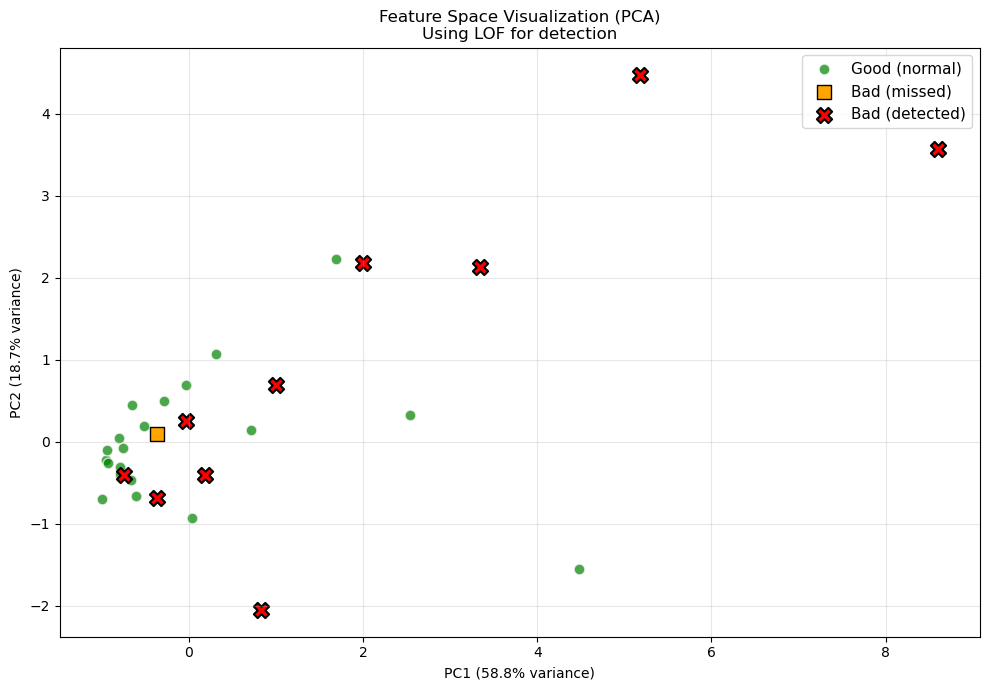


PCA explained variance: 77.5%
Detected: 10/11 bad trials


In [19]:
# =============================================================================
# PCA VISUALIZATION
# =============================================================================
from sklearn.decomposition import PCA

# Reduce features to 2D
pca = PCA(n_components=2)
Z_good = pca.fit_transform(X_good)
Z_bad = pca.transform(X_bad)

# Use best method for coloring
best_scores = results[best_method]['scores']
best_good = best_scores[:len(X_good)]
best_bad = best_scores[len(X_good):]
best_threshold = np.percentile(best_good, 90)

detected_mask = best_bad > best_threshold
Z_bad_detected = Z_bad[detected_mask]
Z_bad_missed = Z_bad[~detected_mask]

plt.figure(figsize=(10, 7))
plt.scatter(Z_good[:, 0], Z_good[:, 1], s=60, alpha=0.7, label="Good (normal)", c='green', edgecolor='white')
if len(Z_bad_missed) > 0:
    plt.scatter(Z_bad_missed[:, 0], Z_bad_missed[:, 1], s=100, marker='s', 
                label="Bad (missed)", c='orange', edgecolor='black')
if len(Z_bad_detected) > 0:
    plt.scatter(Z_bad_detected[:, 0], Z_bad_detected[:, 1], s=120, marker='X', 
                label="Bad (detected)", c='red', edgecolor='black', linewidths=1.5)

plt.legend(fontsize=11)
plt.title(f"Feature Space Visualization (PCA)\nUsing {best_method} for detection")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/pitch_pca_visualization_windowed.png', dpi=150)
plt.show()

print(f"\nPCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"Detected: {detected_mask.sum()}/{len(detected_mask)} bad trials")

In [20]:
# =============================================================================
# SUMMARY
# =============================================================================
print("=" * 60)
print("PITCH ANOMALY DETECTION - SUMMARY")
print("=" * 60)
print(f"\nDataset:")
print(f"  Good trials: {len(pitch_good_ds)}")
print(f"  Bad trials:  {len(pitch_bad_ds)}")
print(f"  Channels:    {C}")
print(f"  Sample rate: {SAMPLING_RATE} Hz")

print(f"\nModel:")
print(f"  Architecture: 1D Convolutional Autoencoder (with dropout)")
print(f"  Latent dim:   64")
print(f"  Weight decay: 1e-3")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  Best val loss:    {best_val_loss:.4f}")
print(f"  Epochs trained:   {len(history['train_loss'])}")

print(f"\nAnomaly Detection Performance:")
print(f"  {'Method':<15} {'ROC-AUC':>10} {'PR-AUC':>10} {'Detected':>12}")
print(f"  {'-'*47}")
for name, data in results.items():
    if name == 'LOF':
        detected = np.sum(lof_pred_bad == -1)
    elif name == 'IsoForest':
        detected = np.sum(iso_pred_bad == -1)
    elif name == 'MSE Max':
        detected = np.sum(mse_max_bad > mse_max_threshold)
    else:  # MSE Mean
        detected = np.sum(mse_mean_bad > mse_mean_threshold)
    print(f"  {name:<15} {data['auc']:>10.4f} {data['ap']:>10.4f} {detected:>5}/{len(X_bad)} bad")

print(f"\nBest method: {best_method} (ROC-AUC = {results[best_method]['auc']:.4f})")

PITCH ANOMALY DETECTION - SUMMARY

Dataset:
  Good trials: 20
  Bad trials:  11
  Channels:    8
  Sample rate: 240 Hz

Model:
  Architecture: 1D Convolutional Autoencoder (with dropout)
  Latent dim:   64
  Weight decay: 1e-3
  Final train loss: 0.2667
  Best val loss:    0.2524
  Epochs trained:   200

Anomaly Detection Performance:
  Method             ROC-AUC     PR-AUC     Detected
  -----------------------------------------------
  LOF                 0.9727     0.9531     7/11 bad
  IsoForest           0.8682     0.7563     8/11 bad
  MSE Max             0.8591     0.8194     7/11 bad
  MSE Mean            0.9227     0.8455     9/11 bad

Best method: LOF (ROC-AUC = 0.9727)


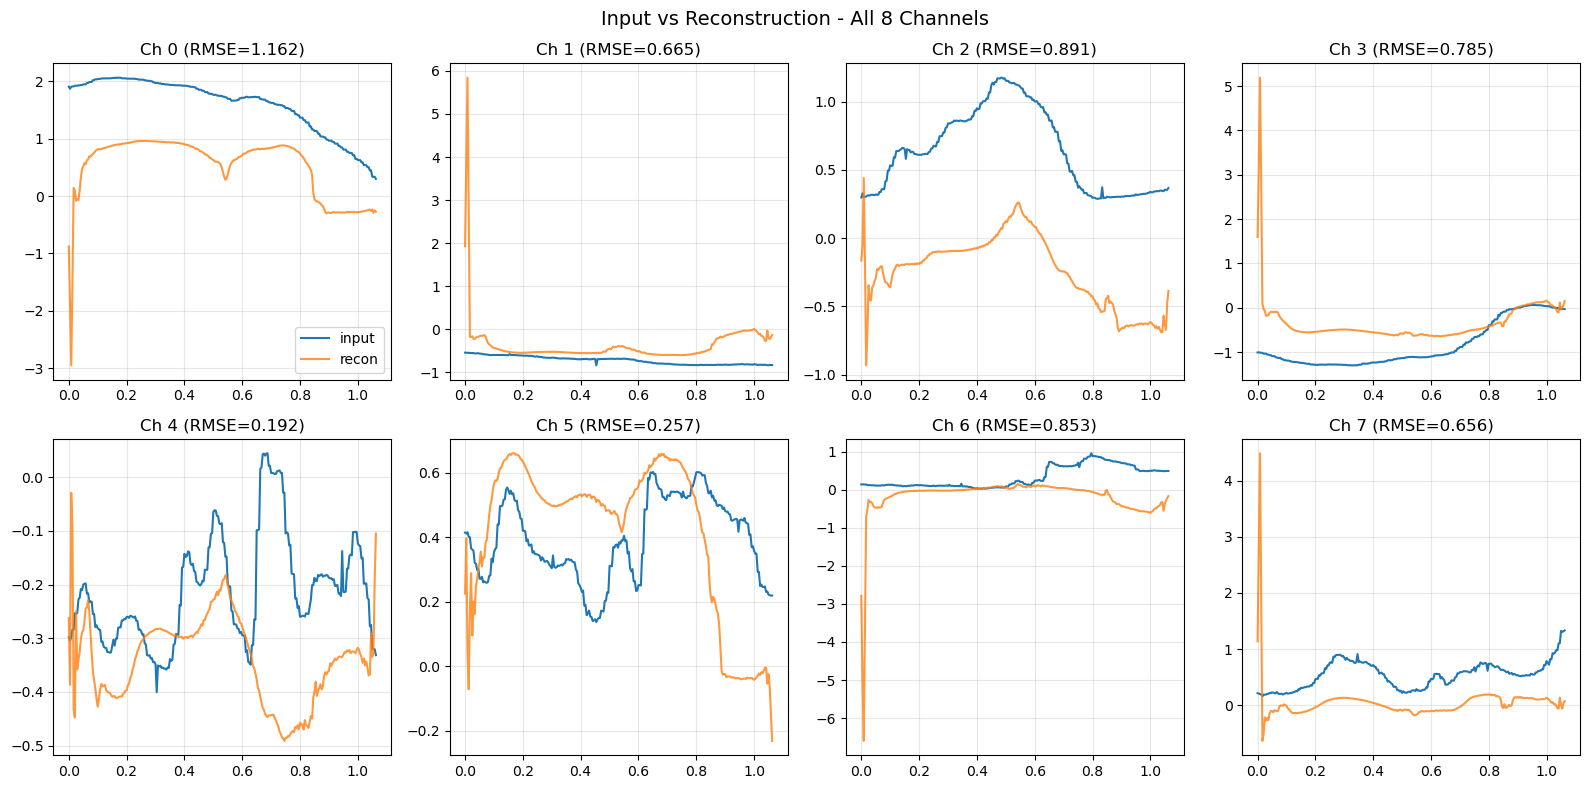

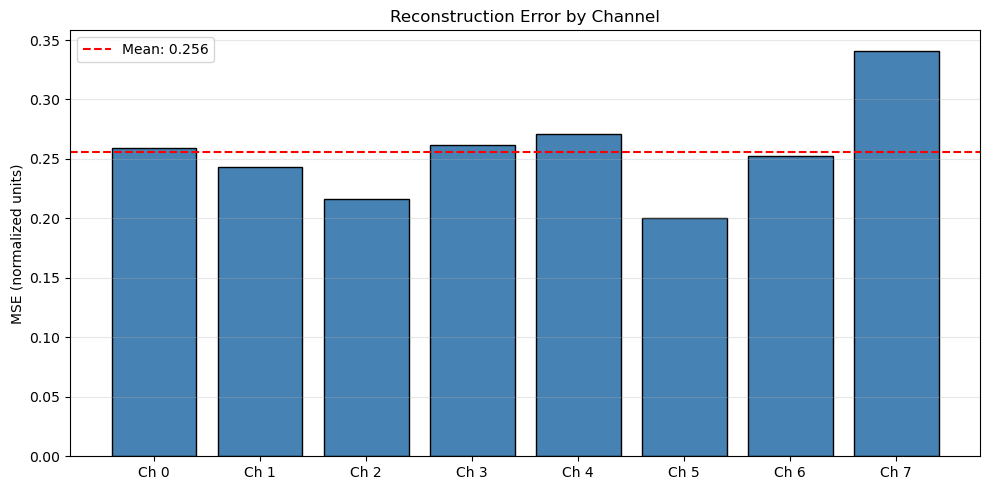

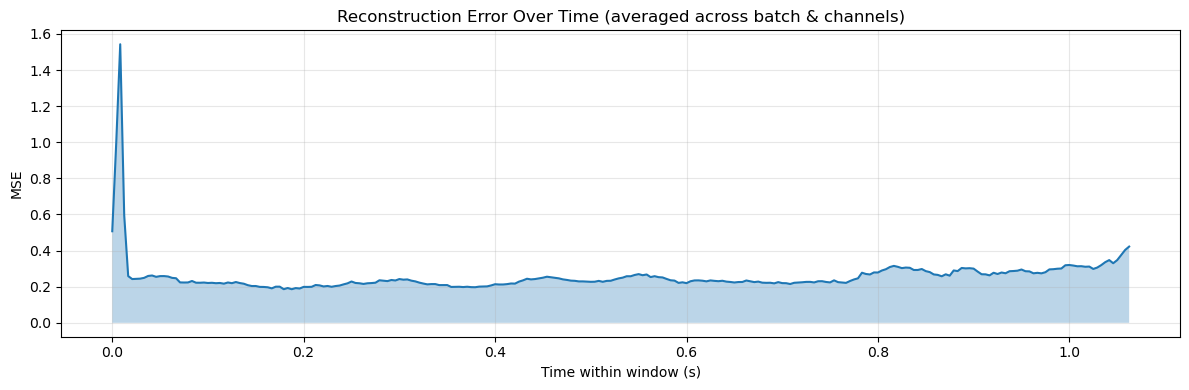

In [21]:
# =============================================================================
# RECONSTRUCTION ERROR ANALYSIS
# =============================================================================
@torch.no_grad()
def visualize_reconstruction_errors(model, loader, ch_mean, ch_std, device, fs=SAMPLING_RATE):
    """Detailed visualization of reconstruction errors."""
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device).float()

    x_n = normalize_batch(x, ch_mean, ch_std)
    y_n, _ = model(x_n)
    y = denorm(y_n, ch_mean, ch_std)
    x_orig = denorm(x_n, ch_mean, ch_std)  # In original units

    T = min(x_orig.size(-1), y.size(-1))
    x_orig, y = x_orig[..., :T], y[..., :T]
    t = np.arange(T) / fs

    # 1. Overlay Plot for sample window
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    e = 0  # First window
    for j in range(8):
        xe = x_orig[e, j, :].cpu().numpy()
        ye = y[e, j, :].cpu().numpy()
        rmse = np.sqrt(((xe - ye)**2).mean())
        axes[j].plot(t, xe, label="input", linewidth=1.5)
        axes[j].plot(t, ye, label="recon", linewidth=1.5, alpha=0.8)
        axes[j].set_title(f"Ch {j} (RMSE={rmse:.3f})")
        axes[j].grid(True, alpha=0.3)
        if j == 0:
            axes[j].legend()
    plt.suptitle("Input vs Reconstruction - All 8 Channels", fontsize=14)
    plt.tight_layout()
    plt.savefig("plots/reconstruction_overlay_all_channels.png", dpi=150)
    plt.show()

    # 2. Per-channel MSE distribution
    errors = (x_n - y_n).pow(2)  # (B, C, T)
    per_channel_mse = errors.mean(dim=(0, 2)).cpu().numpy()  # (C,)

    fig, ax = plt.subplots(figsize=(10, 5))
    channel_names = [f"Ch {i}" for i in range(8)]
    bars = ax.bar(channel_names, per_channel_mse, color='steelblue', edgecolor='black')
    ax.axhline(per_channel_mse.mean(), color='red', linestyle='--', label=f'Mean: {per_channel_mse.mean():.3f}')
    ax.set_ylabel("MSE (normalized units)")
    ax.set_title("Reconstruction Error by Channel")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig("plots/reconstruction_error_by_channel.png", dpi=150)
    plt.show()

    # 3. Error over time within windows
    temporal_mse = errors.mean(dim=(0, 1)).cpu().numpy()  # (T,)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(t, temporal_mse, linewidth=1.5)
    ax.fill_between(t, temporal_mse, alpha=0.3)
    ax.set_xlabel("Time within window (s)")
    ax.set_ylabel("MSE")
    ax.set_title("Reconstruction Error Over Time (averaged across batch & channels)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("plots/reconstruction_error_over_time.png", dpi=150)
    plt.show()

visualize_reconstruction_errors(model, val_loader, ch_mean, ch_std, device)